### Juan David Orjuela - María Sofía Álvarez López

<h1 align='center'>Laboratorio 1: Machine Learning Techniques</h1>

## Problema 
Una de las ventajas que ha brindado la tecnología y la globalización es poder encontrar diferentes referencias de diferentes productos, en especial si son productos de e-commerce, eventos de entretenimiento o reserva de hoteles y parques. En este último, una de las plataformas con mayor interacción a la hora de calificar hoteles es TripAdvisor, ya que permite establecer comentarios sobre hoteles y otorgarles una calificación. 

Ante esta oportunidad de crecimiento turpistica, dada la reactivación económica, han decidido establecer un hotel para poder brindar atención a sus clientes. Y dado que su hotel es bastante nuevo, aún no tienen registros en las grandes plataformas de calificación hotelera, pero si tienen ya varios comentarios en Redes Sociales y quisieran entender cual sería esa posible calificación que tendrían. Para ellos, los expertos en el mercado hotelero le han brindado la información de las reseñas de 2016 de TripAdvisor junto a sus calificaciones.<br>

Ellos han realizado una pre-exploración de los datos, y se han dado cuenta que las calificaciones se encuentran desbalanceadas. Por lo que le han recomendado utilizar una **SVM** para poder combatir este problema, dado que les interesaría con gran importancia saber si la calificación del hotel es muy baja.

También, alguno de sus compañeros Analistas de Datos, al ver que el problema es de textos. Le recomendó utilizar un **modelo estadístico**, con el fin de establecer una primera aproximación que les pueda ayudar a entender mejor el problema.

Y por último, dada su investigación que ha realizado sobre técnicas de Aprendizaje de Datos, ha establecido que las **Redes Neuronales Artificiales** pueden brindar un buen modelo que ayude a generalizar este análisis de sentimientos.

In [1]:
# ESAI
import inflect
import numpy as np
import contractions
import pandas as pd
import re, string, unicodedata
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer

## 1. Entendimiento del problema
Lo primero que hacemos es cargar las librerías y el conjunto de datos, con el fin de entender a qué nos estamos enfrentando.

In [2]:
reviews = pd.read_csv('reviews.csv', delimiter=',')

Con esto, podemos ver una muestra de los datos. Aquí, nos damos cuenta que nuestro conjunto de datos consiste de dos columnas: "Review", con las reseñas de los clientes (escritas en inglés), y "Rating", con la puntuación dada por el cliente de acuerdo con su visita al hotel. Asimismo, vemos que tenemos 20491 reseñas.

In [3]:
print("Tamaño del conjunto de datos:", len(reviews))
reviews.sample(5)

Tamaño del conjunto de datos: 20491


,Review,Rating
10766,great views room pleased room comfy bed large ...,4
7906,"great hotel location, hotel great location cab...",4
887,choice sf love high tech look service make com...,5
19077,excellent value apprehensive arrival hotel sta...,5
12064,"nice stay nice stay, great location close town...",4


Asimismo, vemos que las calificaciones están dadas en un rango de 1-5. A priori, leyendo algunas de las reseñas y de acuerdo con las reglas del negocio, sabemos que una puntuación de 1 es muy mala y, una de 5, excelente.

In [4]:
reviews['Rating'].unique()

array([4, 2, 3, 5, 1])

Ahora, queremos ver si nuestro conjunto de datos tiene entradas nulas. Para ello, revisamos si hay reseñas que correspondan con la cadena vacía "" o con un sólo espacio " ". Note que no hay ninguna que satisfaga estas condiciones, pues obtenemos un <i>dataframe</i> vacío, como vemos en la celda a continuación. Podemos hacer también una revisión con el método <code>isna()</code> de <code>pandas</code>. Este indica si hay algún valor de los datos que tenga como valor <code>None</code> o <code>numpy.NaN</code>. Vemos entonces que nuestro conjunto de datos no tiene ni nulos, ni faltantes.

In [5]:
print(reviews.isna().sum())
reviews[(reviews['Review'] == "") | (reviews['Review'] == " ")]

Review    0
Rating    0
dtype: int64


,Review,Rating


Nos damos cuenta ahora de que sólo tenemos una variabe (la reseña) y que la variable objetivo (target) es la puntuación dada por el usuario. Asimismo, partimos el conjunto de datos entre los datos de entrenamiento y de test: esto es crucial, pues, tras entrenar el modelo, debemos validarlo con datos que este nunca había visto. De acuerdo con el libro de Gerón <a href='#geron'>[1]</a>, una buena división entre datos de entrenamiento y test es 80% y 20%, respectivamente. Esta es la división que usaremos para este modelo.

In [6]:
X, Y = reviews['Review'], reviews['Rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,stratify=Y,test_size=0.2, random_state=48)

Con esto, procedemos a hacer todo el entrenamiento sobre el conjunto de $X_{\mathrm{train}},Y_{\mathrm{train}}$ y guardamos el test en la "caja fuerte" hasta que sea el momento de la validación.

Queremos ver la distribución de las clases de nuestro conjunto de datos. Para ello, consideremos el siguiente histograma.

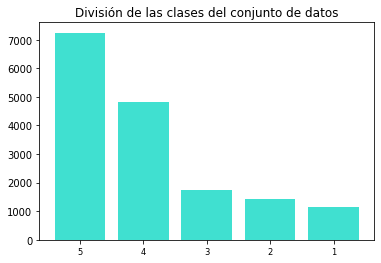

In [7]:
val_counts_y = Y_train.value_counts()
plt.bar(range(len(val_counts_y)), val_counts_y.values, align='center',color='turquoise')
plt.xticks(range(len(val_counts_y)), val_counts_y.index.values, size='small')
plt.title('División de las clases del conjunto de datos')
plt.show()

Podemos ver claramente que, como sugiere el enunciado, las clases están desbalanceadas. Primero que todo, de acuerdo con el enunciado del problema, esto resulta en un inconveniente puesto que nos interesan las reseñas muy bajas (podríamos considerar estas como las clases 1 y 2, incluso la 3), pero estas son las clases con menos (es decir, son las clases minoritarias). Por lo tanto, debemos utilizar técnicas de balanceo de clases. Podemos abordar este problema desde el preprocesamiento, usando técnicas de oversampling como SMOTE, o en la implementación del algoritmo, diciéndole que estamos trabajando con clases desbalanceadas. Quisiéramos ver ambos comportamientos, entonces intentaremos explorar ambas alternativas. Esto se realiza más adelante, en las secciones de preprocesamiento y modelado (respectivamente) de este documento.

---
Como parte final de este entendimiento de los datos, queremos ver (a priori) cuáles son las palabras más utilizadas en el conjunto de datos. Para ello, usamos la librería <code>WordCloud</code>.

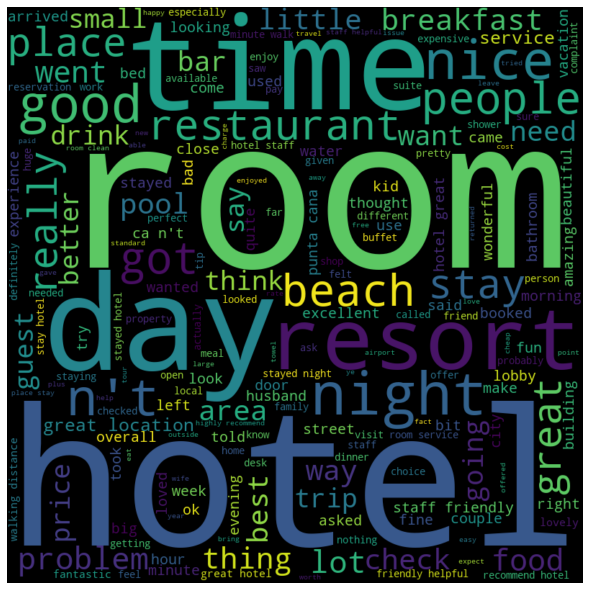

In [8]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,min_font_size = 10).generate(" ".join(data.values))                       
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()
    return wordcloud

wc = wordCloud_generator(X_train)
wc

Con esta nube de palabras, podemos confirmar que nuestra base de datos corresponde a reseñas de hoteles. Note que las palabras "nice", "good", "great" y "friendly", entre otras, resaltan. Esto indica que, en efecto, hay varias críticas positivas (confirmando el desbalance en los datos).

## 2. Preprocesamiento

Antes de hacer cualquier preprocesamiento de los datos asociado a la tokenización y eliminación de palabras no informativas, nos dimos cuenta de que, en la nube de palabras, obtuvimos que una de las "palabras" más comunes es "n't". Sabemos que, en inglés, esta es la contracción de la negación para expresiones como: can't, don't, doesn't, didn't y couldn't, entre otras. Explorando más a fondo el conjunto de datos, nos dimos cuenta de que había una separación extraña entre estas palabras. Por ejemplo, "can't" estaba escrito como "ca n't". Esto es un problema pues, al realizar el preprocesamiento posterior, si tokenizamos, por ejemplo, por palabras, se separaría en dos tokens diferentes (y ca no tiene sentido por sí sola). 

Investigando un poco, encontramos que las contracciones que finalizan en n't en inglés son las que se encuentran en el diccionario a continuación.

In [9]:
our_contractions = { 
"ai n't": "am not",
"are n't": "are not",
"ca n't": "cannot",
"could n't": "could not",
"did n't": "did not",
"does n't": "does not",
"do n't": "do not",
"had n't": "had not",
"has n't": "has not",
"have n't": "have not",
"is n't": "is not",
"may n't": "may not",
"might n't": "might not",
"must n't": "must not",
"need n't": "need not",
"ought n't": "ought not",
"sha n't": "shall not",
"sha' n't": "shall not",
"should n't": "should not",
"was n't": "was not",
"were n't": "were not",
"wo n't": "will not",
"would n't": "would not",
}

def change_contractions(series, our_contractions):
    return series.replace(contractions, regex=True)

Asimismo, leyendo algunas de las reseñas, nos dimos cuenta que había algunos caracteres no ASCII. Por ejemplo, nos dimos cuenta de que, en una reseña, en vez de decir "piñas coladas" decía "piëÙ_a coladas". Otros ejemplos extraños que encontramos (seguramente por errores en las tildes o apóstrofes usados) son: wasn_Çé_, cafÄ au lait, o_Çéælock. Para esto, definimos una función que quite los caracteres no ASCII para las palabras (tokens) de cada documento del corpus.

In [10]:
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

Asimismo, es importante que todas las palabras tengan una capitalización homogénea (en este caso, queremos que estén en minúscula). 

In [21]:
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

Por otro lado, nos dimos cuenta de que la puntuación no provee información adicional en el contexto. Si no se elimina, puede aumentar la dimensionalidad de los datos. Por ejemplo, no tiene sentido tener "almuerzo!" y "almuerzo" como palabras diferentes. Para ello, removemos toda la puntuación usando expresiones regulares.

In [12]:
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

Ahora, consideramos que los números no proveen información relevante. Por ejemplo, hay precios que no se repetirán con frecuencia entre los documentos, porque pueden referirse a productos diferentes o a visitas en años diferentes (y los precios cambian entre años, por factores como la inflación). Por ejemplo, si una reseña dice algo como: "Eso estaba muy costoso, su precio era de 18.50", es suficiente con quedarnos con el hecho de que era muy costoso. 

In [25]:
def remove_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if not word.isnumeric():
            new_words.append(word)
    return new_words

Por un argumento similar, podemos eliminar las fechas de estadía que algunos clientes hayan podido incluir en sus reseñas. Esto es información irrelevante para el análisis de sentimientos.

In [26]:
def remove_dates(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'\d+/\d+/\d+', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

Como última etapa del preprocesamiento, eliminamos las palabras que no contribuyen al contexto. Para ello, usamos dos listas. Primero, usamos las "stop words" características del inglés, usando el módulo <code>stopwords</code> de la librería <code>nltk</code>. 

La otra lista corresponde a las palabras de mayor frecuencia entre los documentos del corpus que consideramos no aportan significativamente al análisis de sentimientos. Veamos las 10 primeras palabras que obtuvimos de la nube de palabras que hicimos en el preprocesamiento.

In [27]:
print(list(wc.words_.keys())[:10])
our_stopwords = list(wc.words_.keys())[:10]

['room', 'hotel', 'day', 'time', 'resort', 'night', 'nice', 'good', "n't", 'people']


Vemos que las 6 primeras palabras son demasiado generales y aplican a cualquier tipo de reseña sin emitir un juicio de valor que nos permita relacionarlo con el puntaje asignado por el usuario. No obstante, "nice" y "good" sí informan sobre la experiencia. Podemos catalogar como "stop-words" a las 6 primeras palabras de esta lista y eliminarlas de nuestro conjunto de datos.

In [28]:
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english') and word not in our_stopwords:
            new_words.append(word)
    return new_words

Finalmente, definimos una función con todos los pasos de eliminación del ruido que definimos previamente. 

In [29]:
def noise_elimination(words):
    words = to_lowercase(words)
    words = remove_non_ascii(words)
    words = remove_numbers(words)
    words = remove_dates(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

Con esto, ya tenemos casi listo nuestro proceso de eliminación del ruido. Antes de eso, primero llamamos a la función <code>fix</code> de la librería <code>contractions</code>. Esta elimina todas las ocurrencias de contracciones en inglés, cambiándolas por las palabras "completas" que representan. Una vez realizado este paso, "tokenizamos" las reseñas. Para poder evaluar cada palabra por separado y aplicar los pasos de preprocesamiento, hacemos la tokenización en palabras individuales usando la librería <code>word_tokenize</code>. Finalmente, aplicamos la función <code>noise_elimination</code> definida previamente.

In [30]:
def preprocessing(X):
    new_X_train= X_train.apply(contractions.fix) #Aplica la corrección de las contracciones
    new_X_train = new_X_train.apply(word_tokenize)
    new_X_train = new_X_train.apply(noise_elimination) #Aplica la eliminación del ruido
    return new_X_train

In [31]:
a = preprocessing(X_train)

In [35]:
a.sample(5)

11237    [tip, treated, royally, returned, april, great...
10756    [rundown, unfriendly, overpriced, recommend, o...
3159     [fantastic, brilliant, say, leave, bad, review...
6425     [great, stay, stayed, benjamin, week, disappoi...
12370    [adore, place, stay, home, away, home, better,...
Name: Review, dtype: object

In [ ]:
# Sustituir cualquier numero 
re.sub('\d+.*','',a)

<h2 id='bibliografia'>Bibliografía</h2>

---

<a id='geron'>[1]</a> Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow : concepts, tools, and techniques to build intelligent systems. Sebastopol, CA: O'Reilly Media. ISBN: 978-1491962299
